In [4]:
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
transformation = transforms.Compose([
                        transforms.ToTensor(),#将读取数据转化为tensor,
                                              #转化到0-1之间
                                              #会将channel放在第一维度
])

In [7]:
train_ds = datasets.MNIST(r'C:\Users\hang\Desktop\pytorch\data', 
                            train= True, 
                            transform= transformation, 
                            download= True)

In [8]:
test_ds = datasets.MNIST(r'C:\Users\hang\Desktop\pytorch\data', 
                            train= False, 
                            transform= transformation, 
                            download= True)

In [9]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 64, shuffle = True)#将输入数据包装成一个traindataset
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 256)

In [10]:
imgs, labels = next(iter(train_dl))

In [11]:
img = imgs[0]
img.shape

torch.Size([1, 28, 28])

In [12]:
img = img.numpy()
img = np.squeeze(img)
img.shape

(28, 28)

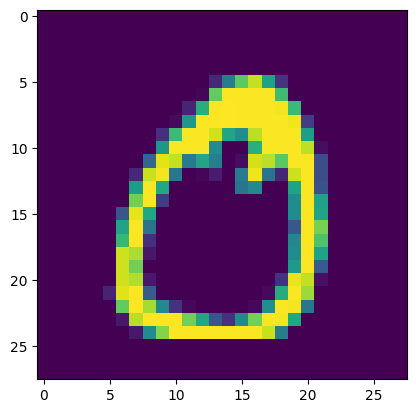

In [13]:
plt.imshow(img)

In [14]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.squeeze(npimg)
    plt.imshow(npimg)

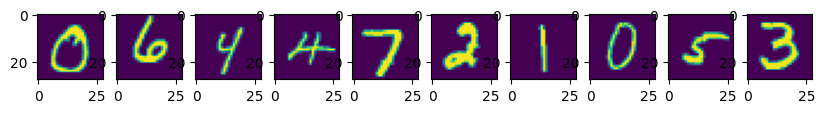

In [15]:
plt.figure(figsize=(10 ,1))
for i, img in enumerate(imgs[: 10]):
    plt.subplot(1, 10, i + 1)
    imshow(img)

In [16]:
#手写数字只有10个所以是10分类
#创建模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)# 卷积层 1代表输入的通道数，6代表输出的通道数，5代表卷积核的大小
        self.pool = nn.MaxPool2d((2, 2))# 池化层
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.liner_1 = nn.Linear(16 * 4 * 4, 256)
        self.liner_2 = nn.Linear(256, 10)
    def forward(self, input):
        #展平
        x = F.relu(self.conv1(input))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.liner_1(x))
        x = self.liner_2(x)
        return x

In [17]:
model = Model()
model.to(device)

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (liner_1): Linear(in_features=256, out_features=256, bias=True)
  (liner_2): Linear(in_features=256, out_features=10, bias=True)
)

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
def fit(epoch, model, trainloader, testloader):
    #记录正确预测了多少个样本
    correct = 0
    #总共多少个样本
    total = 0
    running_loss = 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim= 1)
            correct += (y_pred == y).sum().item() #算对了多少个样本
            total += y.size(0) #实际样本个数y.sise(0)代表运行样本的个数
            running_loss += loss.item() 
    epoch_loss = running_loss / len(trainloader.dataset) #每个样本的平均loss
    epoch_acc = correct / total #正确率


    test_correct = 0
    test_total = 0
    test_running_loss = 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim= 1) #y_pred真实预测结果
            test_correct += (y_pred == y).sum().item() #算对了多少个样本
            test_total += y.size(0) #实际样本个数y.sise(0)代表运行样本的个数
            test_running_loss += loss.item()
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    print('epoch:', epoch, 
          'loss:', round(epoch_loss, 3),
          'accuray:', round(epoch_acc, 3),
          'test_loss:', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3))

    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [20]:
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 20

In [24]:
train_loss = []
train_acc = []
test_loss = []
test_acc = [] 
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc =  fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 0 loss: 0.001 accuray: 0.988 test_loss: 0.0 test_accuracy: 0.988
epoch: 1 loss: 0.001 accuray: 0.989 test_loss: 0.0 test_accuracy: 0.988
epoch: 2 loss: 0.001 accuray: 0.989 test_loss: 0.0 test_accuracy: 0.987
epoch: 3 loss: 0.001 accuray: 0.99 test_loss: 0.0 test_accuracy: 0.988
epoch: 4 loss: 0.001 accuray: 0.99 test_loss: 0.0 test_accuracy: 0.988
epoch: 5 loss: 0.0 accuray: 0.991 test_loss: 0.0 test_accuracy: 0.99
epoch: 6 loss: 0.0 accuray: 0.991 test_loss: 0.0 test_accuracy: 0.988
epoch: 7 loss: 0.0 accuray: 0.991 test_loss: 0.0 test_accuracy: 0.989
epoch: 8 loss: 0.0 accuray: 0.991 test_loss: 0.0 test_accuracy: 0.99
epoch: 9 loss: 0.0 accuray: 0.992 test_loss: 0.0 test_accuracy: 0.989
epoch: 10 loss: 0.0 accuray: 0.992 test_loss: 0.0 test_accuracy: 0.989
epoch: 11 loss: 0.0 accuray: 0.992 test_loss: 0.0 test_accuracy: 0.99
epoch: 12 loss: 0.0 accuray: 0.993 test_loss: 0.0 test_accuracy: 0.99
epoch: 13 loss: 0.0 accuray: 0.993 test_loss: 0.0 test_accuracy: 0.99
epoch: 14 los

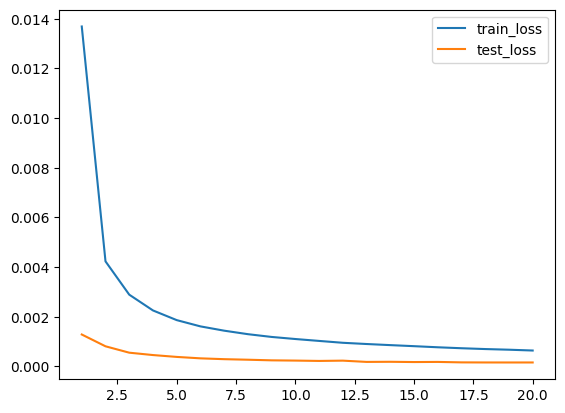

In [22]:
plt.plot(range(1, epochs + 1), train_loss, label = 'train_loss')
plt.plot(range(1, epochs + 1), test_loss, label = 'test_loss')
plt.legend()

In [23]:
# 在GPU上训练只需要两步
# 1、将模型转移到GPU上
# 将每一个批次的训练数据转移到GPU上
